# Practice 3

Integrantes de equipo:
1. Alfonso Murrieta Villegas 
2. C. Nathaniel Ceballos Equihua
3. Felipe de Jesús Solano González
4. Juan Muñoz Marbán


# 0. Bibliotecas y recursos


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
import glob

# 1. Importanción y dataset

In [ ]:
!git clone https://github.com/aMurryFly/Pattern-Recognition.git

Cloning into 'Pattern-Recognition'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 238 (delta 51), reused 185 (delta 17), pack-reused 0
Receiving objects: 100% (238/238), 112.28 MiB | 32.49 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (95/95), done.


In [ ]:
!ls
%cd Pattern-Recognition
!git pull
%cd ..

Pattern-Recognition  sample_data
/content/Pattern-Recognition
Already up to date.
/content


Rutas de los conjuntos para los conjuntos de datos de entrenamiento y prueba

In [ ]:
test_images_dir = "/content/Pattern-Recognition/practices/practice_3/dataset_2/test"
train_images_dir = "/content/Pattern-Recognition/practices/practice_3/dataset_2/train"
original_images_dir = "/content/Pattern-Recognition/practices/practice_3/dataset_2/originals"

Impresión y carga de imágenes 


/content/Pattern-Recognition/practices/practice_3/dataset_2/originals/p1.PNG


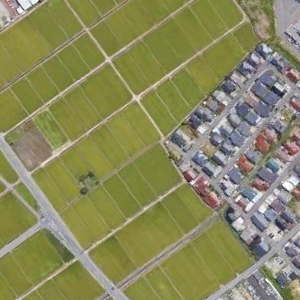

/content/Pattern-Recognition/practices/practice_3/dataset_2/originals/p2.PNG


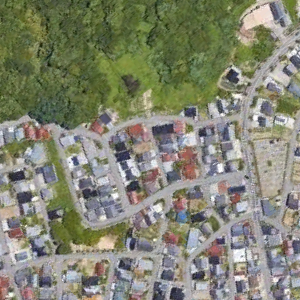

/content/Pattern-Recognition/practices/practice_3/dataset_2/originals/p3.PNG


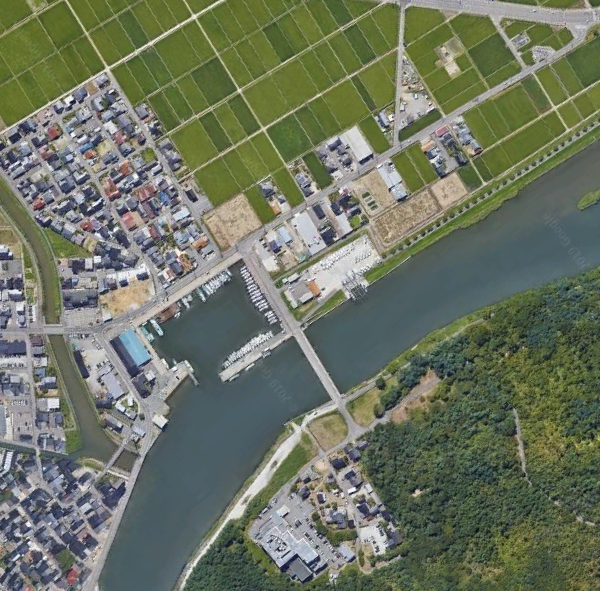

In [ ]:
original_images_list = glob.glob(original_images_dir + '/*.PNG')
original_images_list.sort()

for image in original_images_list:
   print(image)
   img = cv2.imread(image)
   cv2_imshow(img)

/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Forest.png


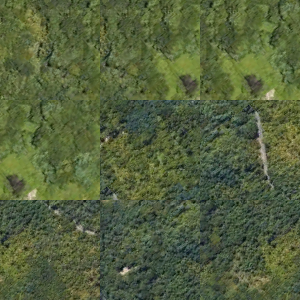

/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Tiled.png


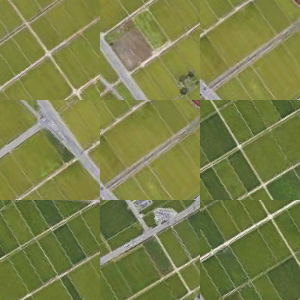

/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Urban.png


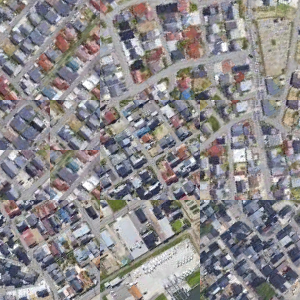

In [ ]:
train_images_list = glob.glob(train_images_dir + '/*.png')
train_images_list.sort()

for image in train_images_list:
   print(image)
   img = cv2.imread(image)
   cv2_imshow(img)

Carga y despliegue de imágenes de prueba


/content/Pattern-Recognition/practices/practice_3/dataset_2/test/p4.PNG


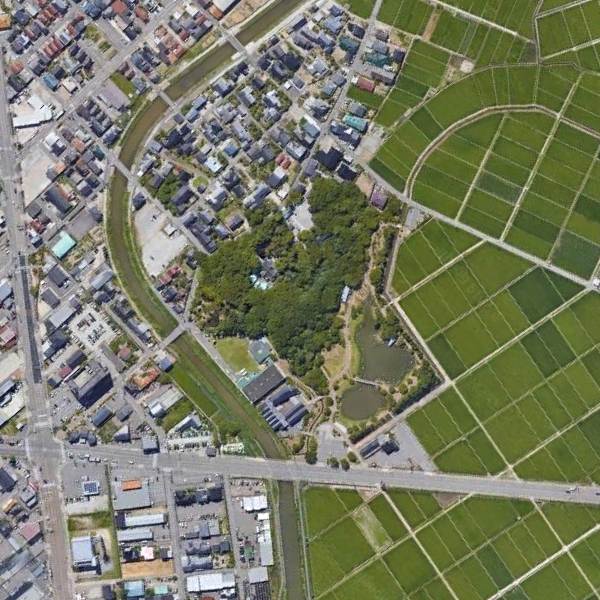

In [ ]:
test_images_list = glob.glob(test_images_dir + '/*.PNG')
test_images_list.sort()

for image in test_images_list:
   print(image)
   img = cv2.imread(image)
   cv2_imshow(img)

# 2. Funciones y reconocimiento de texturas


General libraries (Math and etc) 

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

Bibliotecas para IA

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
%cd /content/Pattern-Recognition/
from cf_matrix import make_confusion_matrix
%cd ..

/content/Pattern-Recognition
/content


## 2.1 Obtención de la matriz GLCM

In [ ]:
def glcm_matrix(matrix, dx , dy):
    GLCM = np.zeros((h_scaleGray+1, h_scaleGray+1))
    for x in range(h_texel_size):
        for y in range(h_texel_size):
          aux_ite = matrix[x,y]
          if not (((x + dx) < 0) or ((y + dy) < 0)):
            try:
              aux_mat = matrix[x + dx, y + dy]
              GLCM[aux_ite,aux_mat] += 1 
            except:
              pass

    GLCM = GLCM.astype(int)
    GLCM += GLCM.T # transpuesta
    GLCM = GLCM / np.sum(GLCM)

    return GLCM

## 2.2 Obtención de estadísticos por texel

In [ ]:
def statistics(GLCM):
    #Estadísticos 
    contraste = 0
    disimilitud = 0
    homogeneidad = 0
    media =  0
    energy = 0
    entropy = 0

    for i in range(h_scaleGray + 1):
        for j in range(h_scaleGray + 1):

            contraste += GLCM[i,j] * ((i-j)**2)
            disimilitud += GLCM[i,j] * abs(i-j)
            homogeneidad += GLCM[i,j] / (1 + ((i-j)**2))
            aux_entropy = 0
            aux_entropy += GLCM[i,j]**2

            if GLCM[i,j] > 0:
                entropy += GLCM[i,j] * (-math.log(GLCM[i,j]))
            media += GLCM[i,j] * i

    energy = math.pow(aux_entropy, (1/2))

    return [contraste, disimilitud, homogeneidad, energy, entropy]

## 2.3 Vectores característicos

In [ ]:
def getStatistics(image):

    #CHECAR NOTA
    angle == 0
    dx = 0
    dy = 1 * p_distance

    aux_image = image.copy()
    feat_vector = []

    for x in range(0, round(heigh / h_texel_size) * h_texel_size, h_texel_size):
        for y in range(0, round(weitgh / h_texel_size) * h_texel_size, h_texel_size):
            entire_size = aux_image[x:x+h_texel_size, y:y+h_texel_size]
            GLCM = glcm_matrix(entire_size, dx, dy)
            feat_vector.append(statistics(GLCM))

    return feat_vector

NOTA:
Para determinar la orientación del texel puede usarse la siguiente tabla

    Ángulo = 0:
      dx = 0 
      dy = 1 * distancia

    Ángulo = 45:
      dx = -1 * distancia
      dy = 1 * distancia

    Ángulo = 90:
      dx = -1 * distancia
      dy = 0

    Ángulo = 135:
      dx = -1 * distancia
      dy = -1 * distancia

# 3. Split data and train part

In [ ]:
#Datos iniciales
h_texel_size = 20
h_scaleGray = 80
p_distance = 1
train_set = 0.80
angle = 0
X_train, Y_train, X_test, Y_test = [], [], [], []

#Obtención de los datos de entrenamiento
for i in range(len(train_images_list)):
  imagen = cv2.imread(train_images_list[i])
  print(train_images_list[i])
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  heigh, weitgh = imagen.shape

  #Escala del valor de los grises
  imagen_grises = ((imagen/255) * h_scaleGray).astype(int)

  #Tamaño de la ventana
  entire_size = int(round(weitgh / h_texel_size) * round(heigh / h_texel_size))

  entire_size_train = int(entire_size * train_set)
  entire_size_test  = entire_size - entire_size_train

  #Caracteristicas
  X = getStatistics(imagen_grises)

  #Separación en entreamiento y prueba 
  X_train += X[:entire_size_train]
  X_test  += X[entire_size_train:]
  Y_train += [i] * entire_size_train
  Y_test  += [i] * entire_size_test

#Se covierte a arreglos de Numpy
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test  = np.asarray(X_test)
Y_test = np.asarray(Y_test)

/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Forest.png
/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Tiled.png
/content/Pattern-Recognition/practices/practice_3/dataset_2/train/Urban.png


Datos obtenidos

In [ ]:
print("X_train ->",X_train.shape)
print("Y_train ->",Y_train.shape)
print("X_test  ->",X_test.shape)
print("Y_test  ->",Y_test.shape)


X_train -> (540, 5)
Y_train -> (540,)
X_test  -> (135, 5)
Y_test  -> (135,)


# 4. Clasificadores

### KNN

In [ ]:
#¿Cual es el mejor valor de K?#

#Listas para guardar metricas y valores de K
valores_k = []
knn_score = []
f1_scores = []

for i in range(1 , 50):
  valores_k.append(i)
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,Y_train)
  score = knn.score(X_test,Y_test)
  knn_score.append(score)
  Y_pred = knn.predict(X_test)
  f1 = f1_score(Y_test,Y_pred,average='macro')
  f1_scores.append(f1)

Evolucion de las metricas

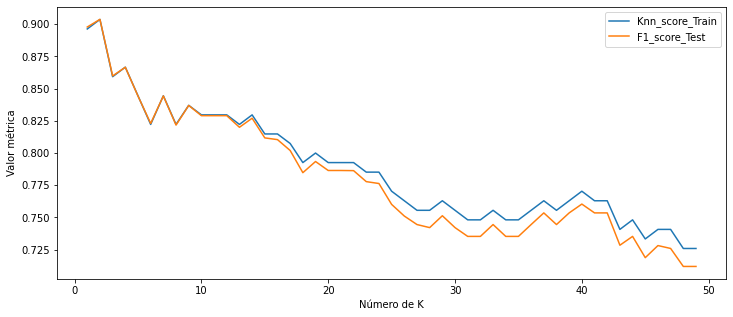

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(valores_k,knn_score, label= 'Knn_score_Train')
plt.plot(valores_k,f1_scores, label= 'F1_score_Test')
plt.ylabel('Valor métrica')
plt.xlabel('Número de K')
plt.legend()
plt.show()

Obtención del mejor valor de K

In [ ]:
Knn_k_max = knn_score.index(max(knn_score))+1
F1_k_max  = f1_scores.index(max(f1_scores))+1
print("El mejor valor según Knn_score para entrenamiento es: ",Knn_k_max)
print("El mejor valor según F1_score para prueba es: ",F1_k_max)

El mejor valor según Knn_score para entrenamiento es:  2
El mejor valor según F1_score para prueba es:  2


Creación del modelo

In [ ]:
KNN_MODEL = KNeighborsClassifier(n_neighbors=F1_k_max)
KNN_MODEL.fit(X_train,Y_train)
Y_pred = KNN_MODEL.predict(X_test)
#Metricas finales 
print("KNN_SCORE final: ",KNN_MODEL.score(X_test,Y_test))
print("F1_SCORE final:  ",f1_score(Y_test,Y_pred,average='macro'))

KNN_SCORE final:  0.9037037037037037
F1_SCORE final:   0.9037629037629039


Matrix de Confusión

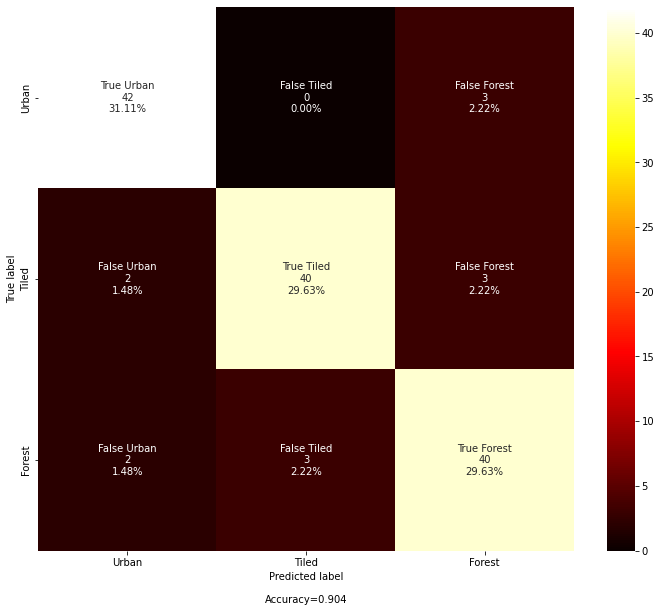

In [ ]:
matriz_confusion = confusion_matrix(Y_test, Y_pred)
labels = ['True Urban', 'False Tiled', 'False Forest', 'False Urban', 'True Tiled', 'False Forest', 'False Urban', 'False Tiled', 'True Forest']
categories = ["Urban", "Tiled", "Forest"]
make_confusion_matrix(matriz_confusion, 
                      group_names = labels,
                      categories = categories, 
                      cmap = 'hot',
                      figsize = (12, 10))

### SVM

In [ ]:
#Lista de posibles kernels
kernels=['linear', 'rbf']
#Listas para guardar metricas y valores de K
valores_k = []
svm_score = []
f1_scores = []

for i in kernels:
  valores_k.append(i)
  svm = SVC(kernel=i)
  svm.fit(X_train,Y_train)
  score = svm.score(X_test,Y_test)
  svm_score.append(score)
  Y_pred = svm.predict(X_test)
  f1 = f1_score(Y_test,Y_pred,average='macro')
  f1_scores.append(f1)

Evolución de las métricas

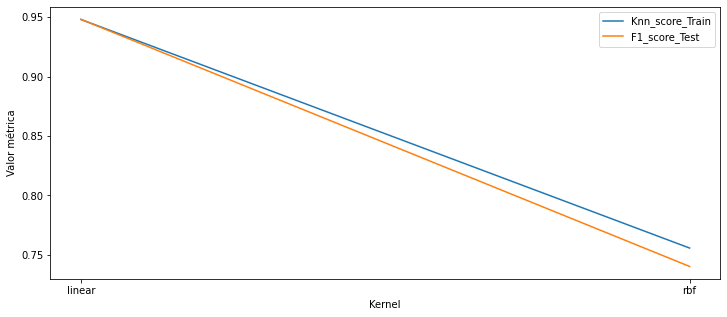

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(valores_k,svm_score, label= 'Knn_score_Train')
plt.plot(valores_k,f1_scores, label= 'F1_score_Test')
plt.ylabel('Valor métrica')
plt.xlabel('Kernel')
plt.legend()
plt.show()

In [ ]:
print("El mejor Kernel según SVM_score para entrenamiento es: ",valores_k[svm_score.index(max(svm_score))])
print("El mejor Kernel según F1_score para prueba es: ",valores_k[f1_scores.index(max(f1_scores))])

El mejor Kernel según SVM_score para entrenamiento es:  linear
El mejor Kernel según F1_score para prueba es:  linear


Creación del modelo

In [ ]:
SVM_MODEL = SVC(kernel= valores_k[f1_scores.index(max(f1_scores))])
SVM_MODEL.fit(X_train,Y_train)
Y_pred = SVM_MODEL.predict(X_test)
#Metricas finales 
print("KNN_SCORE final: ",SVM_MODEL.score(X_test,Y_test))
print("F1_SCORE final:  ",f1_score(Y_test,Y_pred,average='macro'))

KNN_SCORE final:  0.9481481481481482
F1_SCORE final:   0.9482268044065797


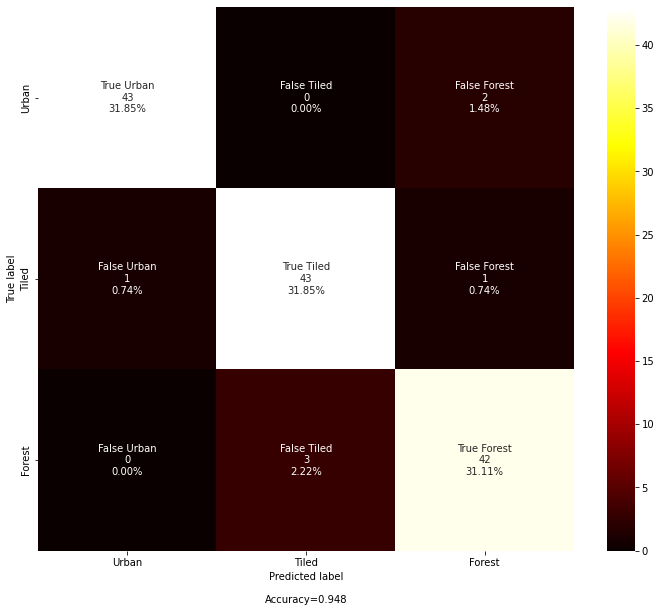

In [ ]:
matriz_confusion = confusion_matrix(Y_test, Y_pred)
labels = ['True Urban', 'False Tiled', 'False Forest', 'False Urban', 'True Tiled', 'False Forest', 'False Urban', 'False Tiled', 'True Forest']
categories = ["Urban", "Tiled", "Forest"]
make_confusion_matrix(matriz_confusion, 
                      group_names = labels,
                      categories = categories, 
                      cmap = 'hot',
                      figsize = (12, 10))

# 5. Clasificación de Imágenes

Función para clasificar imagenes

In [ ]:
def class_painter(image, model):
    # Matriz auxiliar
    Class_Mask = np.zeros(img.shape, np.uint8)

    angle == 0
    dx = 0
    dy = 1 * p_distance

    # Hacer el recorrido de la imagen desde la esquina superior
    for x_i in range(0, round(height / h_texel_size) * h_texel_size, h_texel_size):
        for y_i in range(0, round(width / h_texel_size)*h_texel_size,h_texel_size):
            # Creación de ventana
            ventana = image[x_i:x_i+h_texel_size, y_i:y_i+h_texel_size]
            # Matriz GLCM
            GLCM = glcm_matrix(ventana,dx,dy)
            # Obtención del vector de caracteristicas
            X = statistics(GLCM)
            # Seleccion de clasificador
            if model=="KNN":
                Class = KNN_MODEL.predict([X])
            else:
                Class = SVM_MODEL.predict([X])
            # Se recorre para pintar la imagen
            for x_ii in range(x_i,x_i + h_texel_size):
                for y_ii in range(y_i,y_i + h_texel_size):
                    #Se pinta con el valor de la clase para no pensar mucho xD
                    Class_Mask = cv2.circle(Class_Mask, (y_ii, x_ii), radius=0, color=Gray_Color[int(Class)], thickness=-1)
            
    # Se regresa la imagen clasificada
    imagen_clasificada = cv2.addWeighted(src1=img, alpha=0.02, src2=Class_Mask, beta=0.98, gamma=0)
    return imagen_clasificada

Utilizando imagenes de prueba

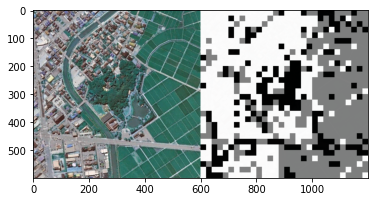

In [ ]:
Gray_Color = [(n, n, n) for n in range(0, 255, (255//(len(train_images_list)-1)))]

#Obtención de los datos de prueba
for i in range(len(test_images_list)):
  img = cv2.imread(test_images_list[i])
  imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width = imagen_grises.shape

  #Escala del valor de los grises
  imagen_grises = ((imagen_grises/255) * h_scaleGray).astype(int)

  #Tamaño de la ventana
  entire_size = int(round(width / h_texel_size) * round(height / h_texel_size))

  #Caracteristicas
  img_class = class_painter(imagen_grises, 'KNN')

  #Impresion de las imagenes
  stack_img = np.hstack((img, img_class))
  plt.imshow(stack_img)
  plt.show()

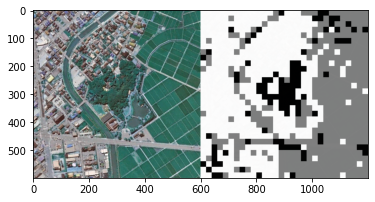

In [ ]:
Gray_Color = [(n, n, n) for n in range(0, 255, (255//(len(train_images_list)-1)))]

#Obtención de los datos de prueba
for i in range(len(test_images_list)):
  img = cv2.imread(test_images_list[i])
  imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width = imagen_grises.shape

  #Escala del valor de los grises
  imagen_grises = ((imagen_grises/255) * h_scaleGray).astype(int)

  #Tamaño de la ventana
  entire_size = int(round(width / h_texel_size) * round(height / h_texel_size))

  #Caracteristicas
  img_class = class_painter(imagen_grises, 'SVM')

  #Impresion de las imagenes
  stack_img = np.hstack((img, img_class))
  plt.imshow(stack_img)
  plt.show()